In [3]:
pip install albumentations==1.3.1

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import cv2
import torch
import random
import json
import numpy as np
import torch.nn as nn
from pathlib import Path
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import torchvision.models.video as video_models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold

In [5]:
CONFIG = {
    'data_root': '9-classes',
    'frame_height': 232,
    'frame_width': 232,
    'num_frames': 32,

    'batch_size': 4,
    'epochs': 8,
    'learning_rate': 1e-3,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'fold' : 3,
    'optimizer': 'sgd',
    'scheduler': 'cosine',
    'dropout': 0.3,

    'model_type': 'r3d',
    'pretrained': False,
}

# Set seed
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


In [6]:
def load_video_paths(data_root):
    video_paths = []
    labels = []
    class_names = sorted(os.listdir(data_root))
    label_to_idx = {name: i for i, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = Path(data_root) / class_name
        for video_file in class_dir.glob("*.mp4"):
            video_paths.append(str(video_file))
            labels.append(label_to_idx[class_name])
    return video_paths, labels, label_to_idx

video_paths, labels, label_to_idx = load_video_paths(CONFIG['data_root'])
idx_to_label = {v: k for k, v in label_to_idx.items()}

In [7]:
class SoccerDataset(Dataset):
    def __init__(self, video_paths, labels, config):
        self.video_paths = video_paths
        self.labels = labels
        self.config = config
        self.transform = A.Compose([
            A.Resize(height=config['frame_height'], width=config['frame_width']),
            A.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989])
        ])

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        path = self.video_paths[idx]
        label = self.labels[idx]
        frames = self._load_video(path)
        return frames, label

    def _load_video(self, path):
        cap = cv2.VideoCapture(path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        indices = np.linspace(0, frame_count - 1, self.config['num_frames'], dtype=int)
        frames = []

        for i in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                continue
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = self.transform(image=frame)['image']
            frames.append(frame)

        cap.release()

        frames = np.array(frames)
        frames = np.transpose(frames, (3, 0, 1, 2))
        return torch.from_numpy(frames).float()


In [9]:
class R3DClassifier(nn.Module):
    def __init__(self, num_classes, config):
        super(R3DClassifier, self).__init__()

        model_type = config['model_type'].lower()
        pretrained = config['pretrained']
        dropout = config['dropout']

        if model_type == 'r3d':
            self.model = video_models.r3d_18(pretrained=pretrained)
        elif model_type == 'mc3':
            self.model = video_models.mc3_18(pretrained=pretrained)
        elif model_type == 'r2plus1d':
            self.model = video_models.r2plus1d_18(pretrained=pretrained)
        else:
            raise ValueError(f"Unsupported model_type '{model_type}' in CONFIG")

        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
k_folds = CONFIG['fold']
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

all_fold_accuracies = []
fold_tracking = []

for fold, (train_idx, val_idx) in enumerate(skf.split(video_paths, labels)):
    print(f"\n{'='*30}\n▶️ Fold {fold+1}/{k_folds}\n{'='*30}")

    train_paths_fold = [video_paths[i] for i in train_idx]
    val_paths_fold = [video_paths[i] for i in val_idx]
    train_labels_fold = [labels[i] for i in train_idx]
    val_labels_fold = [labels[i] for i in val_idx]

    train_loader = DataLoader(SoccerDataset(train_paths_fold, train_labels_fold, CONFIG), batch_size=CONFIG['batch_size'], shuffle=True)
    val_loader = DataLoader(SoccerDataset(val_paths_fold, val_labels_fold, CONFIG), batch_size=CONFIG['batch_size'], shuffle=False)

    model = R3DClassifier(num_classes=len(label_to_idx), config=CONFIG).to(CONFIG['device'])

    criterion = nn.CrossEntropyLoss()

    if CONFIG['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
    elif CONFIG['optimizer'] == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=CONFIG['learning_rate'], momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer in CONFIG.")    
    
    best_val_acc = 0.0
    epoch_train_accs, epoch_val_accs = [], []
    epoch_train_errors, epoch_val_errors = [], []
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_preds, train_targets = [], []

        for videos, labels_batch in tqdm(train_loader, desc=f"Fold {fold+1} - Epoch {epoch+1}"):
            videos, labels_batch = videos.to(CONFIG['device']), labels_batch.to(CONFIG['device'])
            outputs = model(videos)
            loss = criterion(outputs, labels_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            train_targets.extend(labels_batch.cpu().numpy())

        train_acc = accuracy_score(train_targets, train_preds)
        train_errors = sum(p != t for p, t in zip(train_preds, train_targets))

        model.eval()
        val_preds, val_targets = [], []

        with torch.no_grad():
            for videos, labels_batch in val_loader:
                videos, labels_batch = videos.to(CONFIG['device']), labels_batch.to(CONFIG['device'])
                outputs = model(videos)
                val_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
                val_targets.extend(labels_batch.cpu().numpy())

        val_acc = accuracy_score(val_targets, val_preds)
        val_errors = sum(p != t for p, t in zip(val_preds, val_targets))
        print(f"✅ Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")
        
        epoch_train_accs.append(train_acc)
        epoch_val_accs.append(val_acc)
        epoch_train_errors.append(train_errors)
        epoch_val_errors.append(val_errors)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_path = f"models1/best_model_fold{fold+1}.pth"
            torch.save(model.state_dict(), model_path)
            print(f"💾 Saved best model for Fold {fold+1}: {model_path}")
    
    fold_tracking.append({
    'fold': fold + 1,
    'train_accuracies': epoch_train_accs,
    'val_accuracies': epoch_val_accs,
    'train_errors': epoch_train_errors,
    'val_errors': epoch_val_errors,
    'best_val_acc': best_val_acc
    })

    all_fold_accuracies.append(best_val_acc)
    

run_summary = {
    'config': {
        'learning_rate': float(CONFIG['learning_rate']),
        'batch_size': int(CONFIG['batch_size']),
        'dropout': float(CONFIG['dropout']),
        'num_frames': int(CONFIG['num_frames']),
        'optimizer': CONFIG['optimizer'],
        'k_folds': int(CONFIG['fold'])
    },
    'fold_accuracies': [float(a) for a in all_fold_accuracies],
    'avg_accuracy': float(np.mean(all_fold_accuracies)),
    'fold_tracking': fold_tracking  # we’ll sanitize this below
}


def sanitize(obj):
    if isinstance(obj, (np.int64, np.int32, np.integer)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32, np.floating)):
        return float(obj)
    elif isinstance(obj, list):
        return [sanitize(x) for x in obj]
    elif isinstance(obj, dict):
        return {k: sanitize(v) for k, v in obj.items()}
    else:
        return obj

run_summary['fold_tracking'] = sanitize(fold_tracking)

/home/kothari.je/.conda/envs/my_env/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/home/kothari.je/.conda/envs/my_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kothari.je/.conda/envs/my_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



▶️ Fold 1/3


Fold 1 - Epoch 1: 100%|██████████| 118/118 [08:12<00:00,  4.18s/it]


✅ Epoch 1: Train Acc = 0.2170, Val Acc = 0.3517
💾 Saved best model for Fold 1: models1/best_model_fold1.pth


Fold 1 - Epoch 2: 100%|██████████| 118/118 [08:10<00:00,  4.16s/it]


✅ Epoch 2: Train Acc = 0.2915, Val Acc = 0.3771
💾 Saved best model for Fold 1: models1/best_model_fold1.pth


Fold 1 - Epoch 3: 100%|██████████| 118/118 [08:09<00:00,  4.15s/it]


✅ Epoch 3: Train Acc = 0.3617, Val Acc = 0.4788
💾 Saved best model for Fold 1: models1/best_model_fold1.pth


Fold 1 - Epoch 4: 100%|██████████| 118/118 [08:09<00:00,  4.15s/it]


✅ Epoch 4: Train Acc = 0.4404, Val Acc = 0.4703


Fold 1 - Epoch 5: 100%|██████████| 118/118 [08:08<00:00,  4.14s/it]


✅ Epoch 5: Train Acc = 0.4447, Val Acc = 0.5763
💾 Saved best model for Fold 1: models1/best_model_fold1.pth


Fold 1 - Epoch 6: 100%|██████████| 118/118 [08:09<00:00,  4.14s/it]


✅ Epoch 6: Train Acc = 0.5000, Val Acc = 0.4619


Fold 1 - Epoch 7: 100%|██████████| 118/118 [08:11<00:00,  4.17s/it]


✅ Epoch 7: Train Acc = 0.5064, Val Acc = 0.4958


Fold 1 - Epoch 8:  81%|████████  | 95/118 [06:38<01:35,  4.13s/it]

In [10]:
with open(f"run_result_lr_1{CONFIG['learning_rate']}.json", "w") as f:
    json.dump(run_summary, f, indent=2)

NameError: name 'run_summary' is not defined

In [11]:
import json
import matplotlib.pyplot as plt

with open(f"run_result_lr{CONFIG['learning_rate']}.json") as f:
    results = json.load(f)

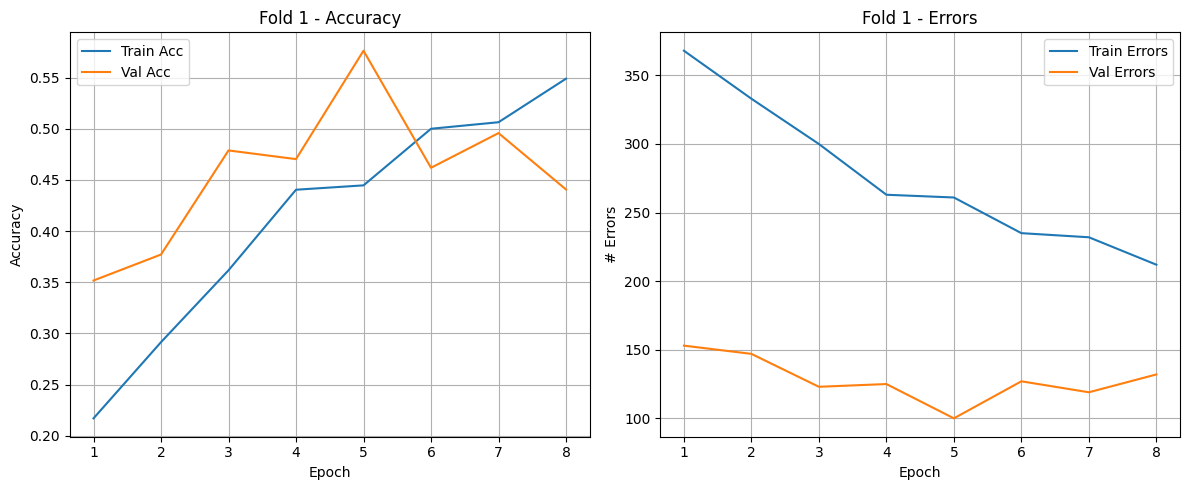

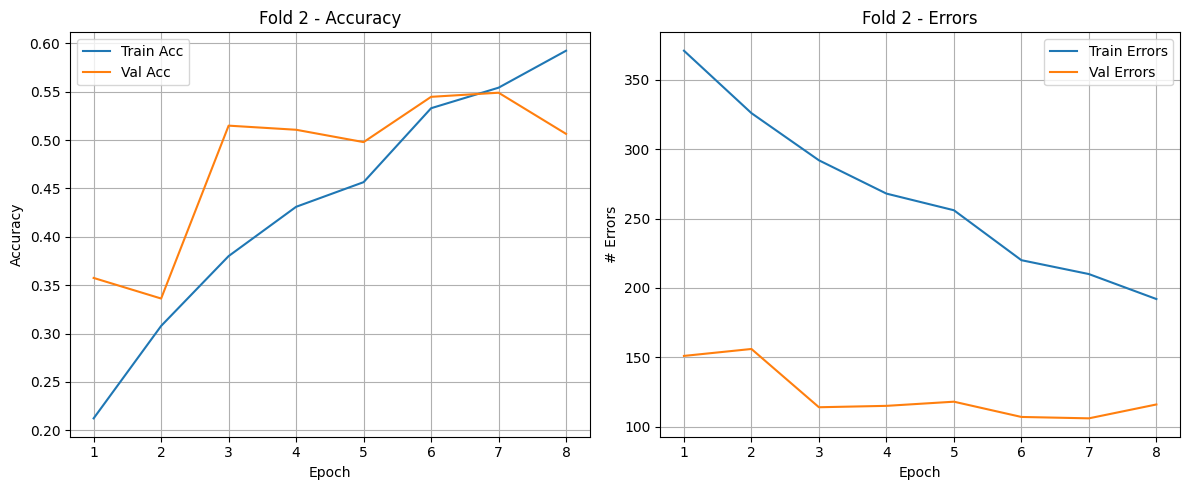

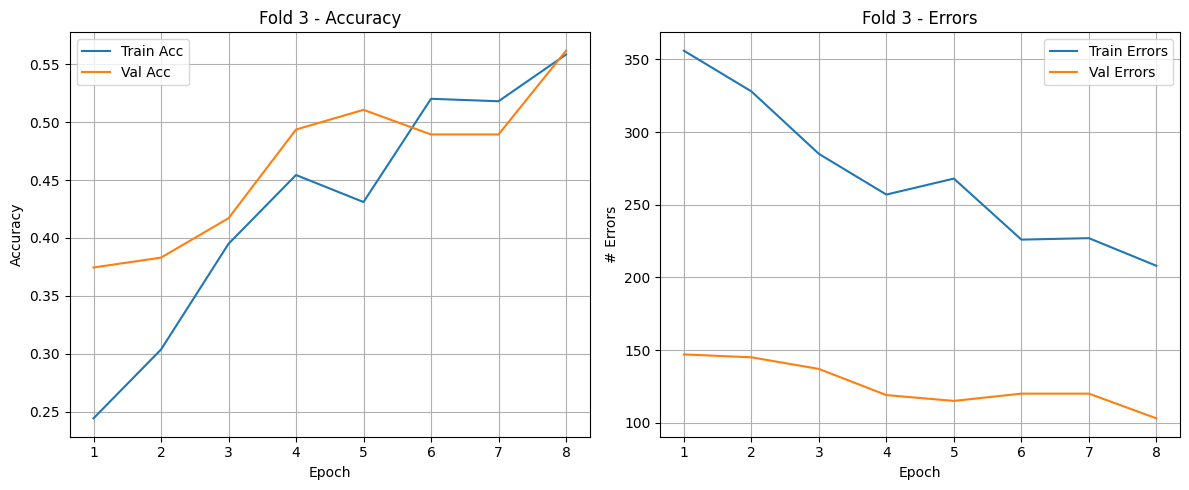

In [12]:
for fold in results['fold_tracking']:
    f = fold['fold']
    epochs = list(range(1, len(fold['train_accuracies']) + 1))
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, fold['train_accuracies'], label='Train Acc')
    plt.plot(epochs, fold['val_accuracies'], label='Val Acc')
    plt.title(f"Fold {f} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Error Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, fold['train_errors'], label='Train Errors')
    plt.plot(epochs, fold['val_errors'], label='Val Errors')
    plt.title(f"Fold {f} - Errors")
    plt.xlabel("Epoch")
    plt.ylabel("# Errors")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [13]:
for fold in results['fold_tracking']:
    print(f"Fold {fold['fold']} | Best Val Accuracy: {fold['best_val_acc']:.4f} | Final Train Accuracy: {fold['train_accuracies'][-1]:.4f}")


Fold 1 | Best Val Accuracy: 0.5763 | Final Train Accuracy: 0.5489
Fold 2 | Best Val Accuracy: 0.5489 | Final Train Accuracy: 0.5924
Fold 3 | Best Val Accuracy: 0.5617 | Final Train Accuracy: 0.5584


In [18]:
df = pd.read_csv('fold_predictions.csv')

# Total errors
total = len(df)
errors = df[~df['correct']]
print(f"\nTotal errors: {len(errors)} out of {total} ({100*len(errors)/total:.2f}%)")

# Most common misclassifications
misclass_df = errors.groupby(['true_label', 'predicted_label']).size().reset_index(name='Count')
misclass_df = misclass_df.sort_values('Count', ascending=False)
print("\nMost common misclassifications:")
print(misclass_df.head(10))

# Error rate by class
class_errors = df.groupby('true_label')['correct'].agg(['count', lambda x: (~x).sum()])
class_errors.columns = ['Total', 'Errors']
class_errors['Error Rate'] = class_errors['Errors'] / class_errors['Total']
class_errors = class_errors.sort_values('Error Rate', ascending=False)
print("\nError rates by class:")
print(class_errors)

# Highest confidence incorrect predictions
print("\nHighest confidence errors:")
print(errors.sort_values('confidence', ascending=False).head(10)[['video_path', 'true_label', 'predicted_label', 'confidence']])




Total errors: 103 out of 235 (43.83%)

Most common misclassifications:
          true_label   predicted_label  Count
18   Shots on target              Foul     16
6               Goal  Shots off target     15
20   Shots on target  Shots off target     14
11          Kick-off       Yellow card     11
15  Shots off target              Foul      7
5               Goal              Foul      7
21       Yellow card            Corner      5
17   Shots on target            Corner      3
9           Kick-off              Foul      3
22       Yellow card          Kick-off      3

Error rates by class:
                  Total  Errors  Error Rate
true_label                                 
Penalty               1       1    1.000000
Shots on target      34      34    1.000000
Red card              1       1    1.000000
Goal                 34      24    0.705882
Kick-off             33      17    0.515152
Shots off target     33      10    0.303030
Yellow card          33       8    0.242424
Cor

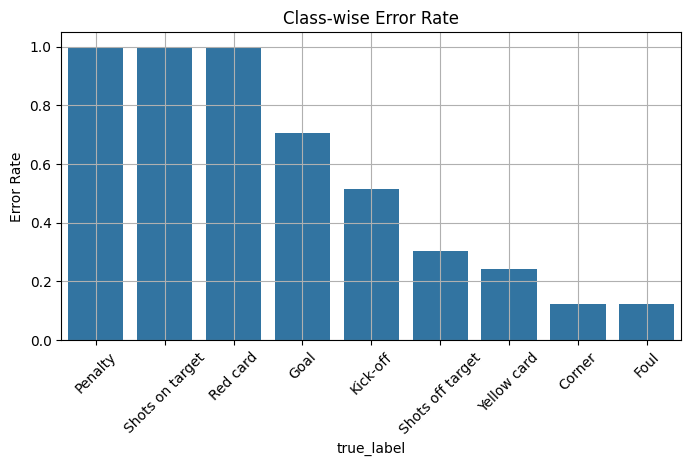

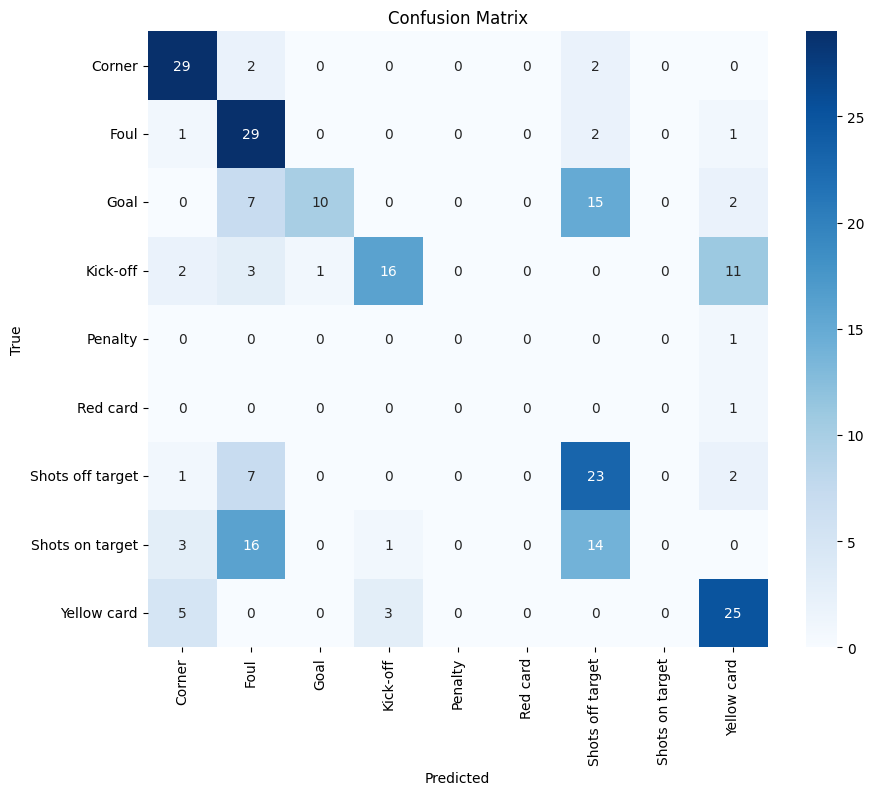

In [19]:
# Error rate bar plot
plt.figure(figsize=(8, 4))
sns.barplot(x=class_errors.index, y=class_errors['Error Rate'])
plt.title("Class-wise Error Rate")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Confusion Matrix
cm = confusion_matrix(df['true_label'], df['predicted_label'], labels=list(label_to_idx.keys()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_idx.keys(), yticklabels=label_to_idx.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
